<a href="https://colab.research.google.com/github/YABZIE/Computational-Intelligence-End-Term-Task_Nicandro-Jabez-Teguh/blob/main/EndTermTask_Nicandro_Jabez_Teguh_2106726056.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pendahuluan**
*OCR*

*Optical Character Recognition (OCR) adalah salah satu tugas penting dalam visi komputer dan Kecerdasan Buatan, karena beragamnya bahasa yang ditulis dan beragam font untuk bahasa yang sama. Tugas kami adalah membuat OCR dan deteksi teks untuk teks berbahasa Inggris*

*- Dataset yang kami gunakan adalah OCR-Dataset yang berisi lebih dari 200.000 gambar karakter alfanumerik dalam huruf besar dan kecil. - Target kami adalah mendeteksi karakter huruf kecil saja dalam teks yang digunakan dalam proyek ini.*

> Dataset ini dihasilkan menggunakan 3475 gaya font yang tersedia di Google Fonts. Setiap karakter alfanumerik (huruf besar, huruf kecil, dan angka) dihasilkan dalam setiap gaya font dan disimpan dalam direktori. Total ukuran dataset: 210 ribu gambar untuk 62 kelas OCR-Dataset

![](https://www.cheggindia.com/wp-content/uploads/2023/08/ocr-full-form.png)


# 1) Importing Libraries

In [ ]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer,GlobalAveragePooling2D


# 2) Helper Functions & Hyperparameters

- **Bagian ini mendefinisikan semua fungsi bantu yang digunakan di seluruh notebook dan hiperparameter apa pun yang akan digunakan nanti untuk melatih model.**

In [ ]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-

    path: String -> the main folder directory that contains train/test folders

    ________________________________________________________________________________________________
    Return-

    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])

    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:

    path: String -> a directory of the image
    _____________________________________________________________
    Return:

    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:

    img: numpy.array of N-D

    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:

    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()

def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [ ]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

# 3) Reading & preparing the dataset

In [ ]:
!pip install opendatasets

key c977b2c8a46b1e46b821b617cec92f40


In [ ]:
import opendatasets as od

# URL of the Kaggle dataset
dataset_url = 'https://www.kaggle.com/datasets/harieh/ocr-dataset'
od.download(dataset_url)


Skipping, found downloaded files in "./ocr-dataset" (use force=True to force download)


In [ ]:
# Reading the dataset in dataframe
main_path = '/content/ocr-dataset/dataset'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,/content/ocr-dataset/dataset/i_L/I_L_2583.png,i
1,/content/ocr-dataset/dataset/i_L/I_L_3442.png,i
2,/content/ocr-dataset/dataset/i_L/I_L_975.png,i
3,/content/ocr-dataset/dataset/i_L/I_L_1832.png,i
4,/content/ocr-dataset/dataset/i_L/I_L_3415.png,i


In [ ]:
df['label'].value_counts()

,count
label,
e,3284
r,3284
n,3281
a,3281
m,3281
q,3279
u,3278
i,3277
d,3277


## 3.1) Splitting the dataframe
- Dataframe dibagi untuk mendapatkan 70% dari dataset untuk pelatihan, dan 30% untuk pengujian.
- Set pelatihan dibagi lagi menjadi pelatihan dan validasi untuk meningkatkan proses pelatihan model.

In [ ]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [ ]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

## 3.2) Creating generators
- ImageDataGenerators digunakan untuk augmentasi data, augmentasi ini diperlukan karena OCR dapat bekerja dengan tingkat kecerahan yang berbeda, yang tidak termasuk dalam dataset.
- Selain itu, ini meningkatkan penggunaan RAM.

In [ ]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [ ]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

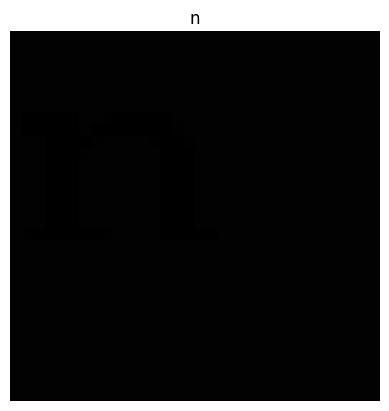

The shape of the image: (32, 32, 3)


In [ ]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

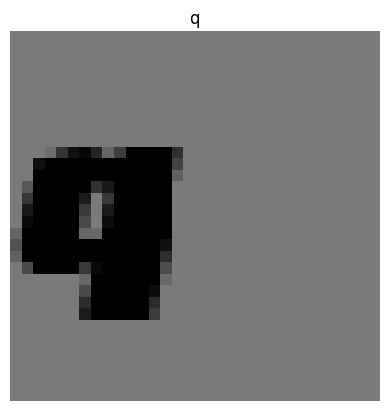

The shape of the image: (32, 32, 3)


In [ ]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4) Modeling
Target kami adalah membangun model CNN kustom untuk dilatih pada gambar yang ditargetkan untuk aplikasi OCR. Selain itu, kami juga akan menggunakan 4 model pra-terlatih sebagai bagian dari Transfer Learning untuk meningkatkan kinerja aplikasi.

Model pra-terlatih yang ditargetkan adalah sebagai berikut:

- EfficientNetB7

- MobileNetV2

- VGG19

- DenseNet121

Strategi fine-tuning: Menggunakan nilai LR kecil pada optimizer Adam akan memaksimalkan penggunaan model pra-terlatih pada dataset kami tanpa MEMBEKU lapisan input, karena kinerja yang lebih baik diperlukan dalam kasus kami.

## 4.1) Custom CNN

In [ ]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [ ]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 32, 3)             │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 30, 30, 128)           │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 10, 10, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 8, 8, 256)             │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 8, 8, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 4, 4, 256)             │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 2, 2, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 2, 2, 512)             │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 2, 2, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 2, 2, 1024)            │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 1, 1, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 1024)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1024)                  │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 26)                    │          26,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,243,502 (20.00 MB)

 Trainable params: 5,243,502 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [ ]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn.keras"))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4669 - loss: 1.9875
Epoch 1: val_loss improved from inf to 0.47119, saving model to CustomCnn.keras_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - accuracy: 0.4672 - loss: 1.9863 - val_accuracy: 0.8742 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 2/20
1392/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8685 - loss: 0.4847
Epoch 2: val_loss improved from 0.47119 to 0.39338, saving model to CustomCnn.keras_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - accuracy: 0.8686 - loss: 0.4846 - val_accuracy: 0.8979 - val_loss: 0.3934 - learning_rate: 0.0010
Epoch 3/20
1392/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8949 - loss: 0.3890
Epoch 3: val_loss improved from 0.39338 to 0.33153, saving model to CustomCnn.keras_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.8949 - loss: 0.3890 - val_accuracy: 0.9140 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 4/20
1397/1398 ━━━━

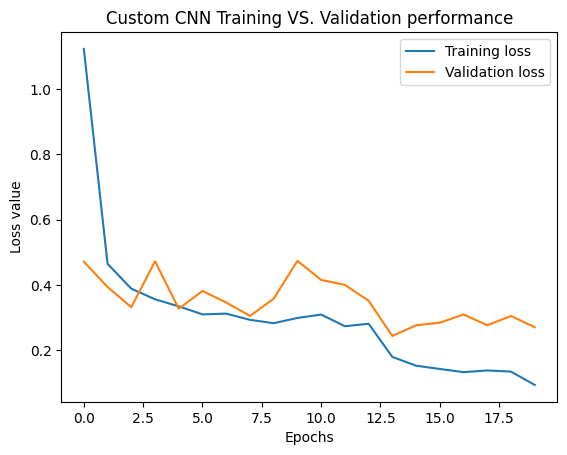

In [ ]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


In [ ]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.96      0.96      0.96      1010
           b       0.96      0.97      0.97       948
           c       0.96      0.95      0.96       970
           d       0.98      0.96      0.97      1014
           e       0.93      0.95      0.94      1003
           f       0.97      0.94      0.96      1001
           g       0.97      0.94      0.95       959
           h       0.95      0.96      0.96       933
           i       0.97      0.93      0.95      1002
           j       0.96      0.97      0.97       927
           k       0.98      0.95      0.97       974
           l       0.94      0.94      0.94       972
           m       0.96      0.97      0.97       981
           n       0.94      0.95      0.95       963
           o       0.94      0.96      0.95       974
           p       0.97      0.95      0.96       996
           q       0.96      0.94      0.

## 4.2) EfficientNetB7

In [ ]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(InputLayer(input_shape=IMG_SIZE))
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
EffNetB7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 1, 1, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,622,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,258,289 (256.57 MB)

 Trainable params: 66,947,562 (255.38 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [ ]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1708 - loss: 3.0602
Epoch 1: val_loss improved from inf to 1.91642, saving model to EfficientNetB7_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 535s 212ms/step - accuracy: 0.1709 - loss: 3.0598 - val_accuracy: 0.4557 - val_loss: 1.9164 - learning_rate: 1.0000e-05
Epoch 2/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5724 - loss: 1.5078
Epoch 2: val_loss improved from 1.91642 to 1.14053, saving model to EfficientNetB7_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 211s 129ms/step - accuracy: 0.5724 - loss: 1.5077 - val_accuracy: 0.6769 - val_loss: 1.1405 - learning_rate: 1.0000e-05
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7130 - loss: 1.0148
Epoch 3: val_loss improved from 1.14053 to 0.76652, saving model to EfficientNetB7_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 188s 135ms/step - accuracy: 0.7130 - loss: 1.0148 - val_accuracy: 0.7868 - val_loss: 0.7665 - learning_rate: 1.0000e-05
Epoch 4/1

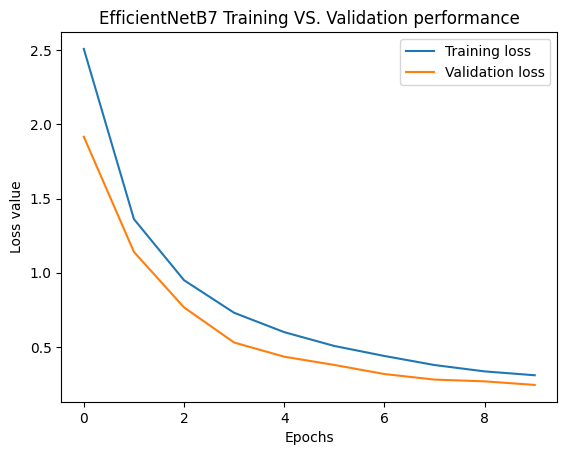

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB7 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 64s 61ms/step


In [ ]:
print('\t     The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

	     The EfficientNetB7 Evaluation Performance
              precision    recall  f1-score   support

           a       0.94      0.90      0.92      1010
           b       0.90      0.94      0.92       948
           c       0.93      0.91      0.92       970
           d       0.98      0.93      0.95      1014
           e       0.91      0.92      0.91      1003
           f       0.92      0.92      0.92      1001
           g       0.91      0.90      0.90       959
           h       0.93      0.92      0.93       933
           i       0.92      0.90      0.91      1002
           j       0.96      0.92      0.94       927
           k       0.95      0.94      0.94       974
           l       0.87      0.93      0.90       972
           m       0.97      0.96      0.96       981
           n       0.94      0.92      0.93       963
           o       0.90      0.95      0.93       974
           p       0.97      0.92      0.94       996
           q       0.95      0.94

## 4.3) MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Pre-defined hyperparameters
IMG_SHAPE = (32, 32, 3)  # (height, width, channels)
opt = Adam(learning_rate=0.00001, epsilon=1e-6)

# Explicit input layer
inputs = Input(shape=IMG_SHAPE)

# Load MobileNetV2 without the top (pre-trained part only)
base_model = MobileNetV2(include_top=False, input_shape=IMG_SHAPE)

# Pass the inputs through the MobileNetV2 base
x = base_model(inputs)

# Flatten the output from the MobileNetV2 base
x = Flatten()(x)

# Add custom dense layers
x = Dense(1024, activation='selu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='selu')(x)

# Output layer for classification (adjust len(mapping) to your number of classes)
outputs = Dense(len(mapping), activation='softmax')(x)

# Define the model
MobNetV2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
MobNetV2.compile(optimizer=opt, loss='categorical_crossentropy')


<ipython-input-26-27646303a8f9>:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_shape=IMG_SHAPE)


In [ ]:
MobNetV2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,107,866 (15.67 MB)

 Trainable params: 4,073,754 (15.54 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

Epoch 1/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0790 - loss: 3.9140
Epoch 1: val_loss improved from inf to 3.32083, saving model to MobileNetV2_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 108s 47ms/step - accuracy: 0.0790 - loss: 3.9137 - val_accuracy: 0.0562 - val_loss: 3.3208 - learning_rate: 1.0000e-05
Epoch 2/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2490 - loss: 2.7602
Epoch 2: val_loss improved from 3.32083 to 2.62138, saving model to MobileNetV2_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.2490 - loss: 2.7600 - val_accuracy: 0.2419 - val_loss: 2.6214 - learning_rate: 1.0000e-05
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3532 - loss: 2.2749
Epoch 3: val_loss improved from 2.62138 to 2.17839, saving model to MobileNetV2_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.3532 - loss: 2.2748 - val_accuracy: 0.3626 - val_loss: 2.1784 - learning_rate: 1.0000e-05
Epoch 4/10
13

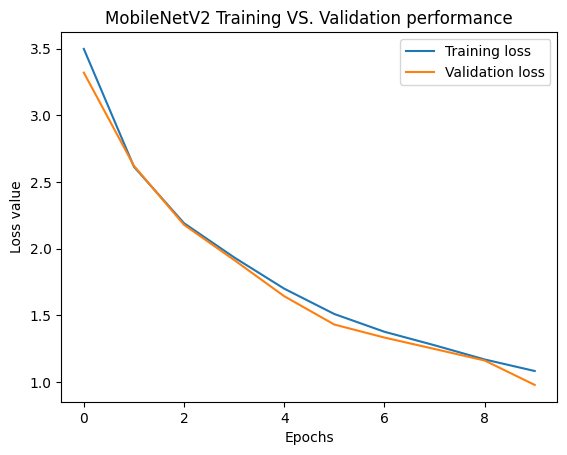

In [ ]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step


In [ ]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

	     The MobileNetV2 Evaluation Performance
              precision    recall  f1-score   support

           a       0.50      0.65      0.56      1010
           b       0.70      0.60      0.64       948
           c       0.64      0.48      0.55       970
           d       0.79      0.66      0.72      1014
           e       0.70      0.49      0.58      1003
           f       0.78      0.67      0.72      1001
           g       0.65      0.77      0.71       959
           h       0.74      0.71      0.73       933
           i       0.65      0.57      0.61      1002
           j       0.73      0.86      0.79       927
           k       0.85      0.82      0.84       974
           l       0.72      0.83      0.77       972
           m       0.72      0.91      0.80       981
           n       0.65      0.66      0.65       963
           o       0.60      0.71      0.65       974
           p       0.72      0.78      0.75       996
           q       0.63      0.57   

## 4.4) VGG19

In [ ]:
# VGG19 input layers will not be FREEZED

train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(InputLayer(input_shape=IMG_SIZE))
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

In [ ]:
VG.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,087,834 (80.44 MB)

 Trainable params: 21,087,834 (80.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.00001)
VG.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

Epoch 1/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6816 - loss: 1.3883
Epoch 1: val_loss improved from inf to 0.42714, saving model to VGG19_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - accuracy: 0.6817 - loss: 1.3878 - val_accuracy: 0.9114 - val_loss: 0.4271 - learning_rate: 1.0000e-05
Epoch 2/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9274 - loss: 0.2853
Epoch 2: val_loss improved from 0.42714 to 0.24123, saving model to VGG19_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 132s 59ms/step - accuracy: 0.9274 - loss: 0.2853 - val_accuracy: 0.9362 - val_loss: 0.2412 - learning_rate: 1.0000e-05
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9446 - loss: 0.1923
Epoch 3: val_loss did not improve from 0.24123
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 66s 47ms/step - accuracy: 0.9446 - loss: 0.1923 - val_accuracy: 0.9402 - val_loss: 0.2451 - learning_rate: 1.0000e-05
Epoch 4/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9

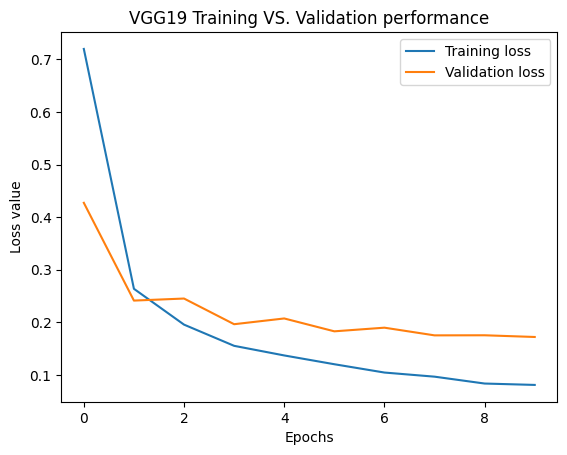

In [ ]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


In [ ]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

		The VGG19 Evaluation Performance
              precision    recall  f1-score   support

           a       0.95      0.97      0.96      1010
           b       0.97      0.96      0.97       948
           c       0.95      0.97      0.96       970
           d       1.00      0.97      0.98      1014
           e       0.90      0.97      0.94      1003
           f       0.98      0.97      0.97      1001
           g       0.99      0.90      0.94       959
           h       0.95      0.98      0.96       933
           i       0.90      0.98      0.93      1002
           j       0.98      0.96      0.97       927
           k       0.99      0.97      0.98       974
           l       0.95      0.92      0.94       972
           m       1.00      0.97      0.98       981
           n       0.96      0.96      0.96       963
           o       0.96      0.97      0.96       974
           p       0.97      0.96      0.96       996
           q       0.95      0.97      0.96   

## 4.5) DenseNet121

In [ ]:
IMG_SIZE

(32, 32, 3)

In [ ]:
from tensorflow.keras.models import Model

# Load the DenseNet121 model without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
# Add a global average pooling layer
x = base_model.output
x = Flatten()(x)
# Add custom Dense layers
x = Dense(1024, activation='selu')(x)
x = Dense(512, activation='selu')(x)
# Add the final output layer (assuming classification with softmax, modify as per your task)
output = Dense(len(mapping), activation='softmax')(x)  # Change the output units based on your number of classes

# Create the final model
Den = Model(inputs=base_model.input, outputs=output)


In [ ]:
Den.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 8,625,242 (32.90 MB)

 Trainable params: 8,541,594 (32.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
optimizers = Adam(learning_rate=0.00001)
Den.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=clbck("DenseNet121"))

Epoch 1/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7541 - loss: 0.8964
Epoch 1: val_loss improved from inf to 0.47881, saving model to DenseNet121_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 98s 70ms/step - accuracy: 0.7542 - loss: 0.8962 - val_accuracy: 0.8679 - val_loss: 0.4788 - learning_rate: 1.0000e-05
Epoch 2/10
1397/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8342 - loss: 0.5836
Epoch 2: val_loss improved from 0.47881 to 0.35489, saving model to DenseNet121_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 93s 66ms/step - accuracy: 0.8342 - loss: 0.5836 - val_accuracy: 0.9011 - val_loss: 0.3549 - learning_rate: 1.0000e-05
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8705 - loss: 0.4487
Epoch 3: val_loss improved from 0.35489 to 0.28524, saving model to DenseNet121_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 95s 68ms/step - accuracy: 0.8705 - loss: 0.4486 - val_accuracy: 0.9217 - val_loss: 0.2852 - learning_rate: 1.0000e-05
Epoch 4/10
139

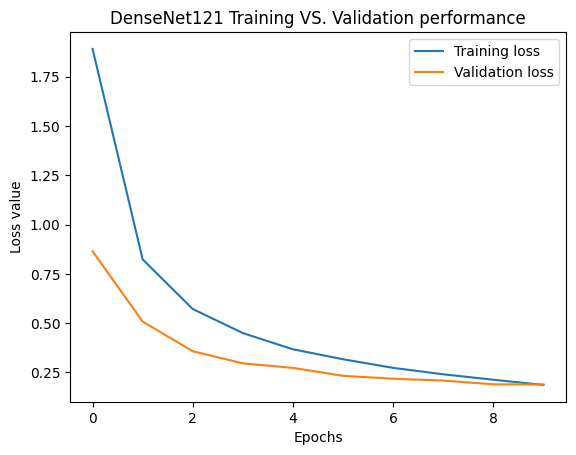

In [ ]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step


In [ ]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.93      0.94      0.93       981
           b       0.96      0.96      0.96       948
           c       0.96      0.93      0.94       974
           d       0.97      0.96      0.97       960
           e       0.94      0.94      0.94      1007
           f       0.95      0.95      0.95       990
           g       0.94      0.93      0.94       933
           h       0.95      0.95      0.95      1009
           i       0.96      0.95      0.95      1009
           j       0.94      0.97      0.95       968
           k       0.97      0.94      0.96      1014
           l       0.94      0.93      0.94       973
           m       0.94      0.97      0.95      1005
           n       0.93      0.95      0.94       982
           o       0.93      0.96      0.94       951
           p       0.96      0.96      0.96       926
           q       0.96      0.97      0

In [ ]:
keras.saving.save_model(Den, "densenet2.keras")

In [ ]:
den2 = keras.saving.load_model("densenet2.keras")

In [ ]:
den2.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_12         │ (None, 38, 38, 3)      │              0 │ input_layer_10[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ zero_padding2d_12[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_13         │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_13[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,617,034 (32.87 MB)

 Trainable params: 8,533,386 (32.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

# 5) Evaluation & Comparison

In [ ]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95],
       'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.93,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN','EfficientNetB7','MobileNetV7','VGG19',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

		The Evaluation results of CNN/Pre-trained models
                accuracy  precision  recall  F1-Score
Custom CNN          0.95       0.96    0.95      0.95
EfficientNetB7      0.93       0.94    0.93      0.93
MobileNetV7         0.71       0.72    0.71      0.71
VGG19               0.96       0.96    0.96      0.96
DenseNet121         0.95       0.95    0.95      0.95


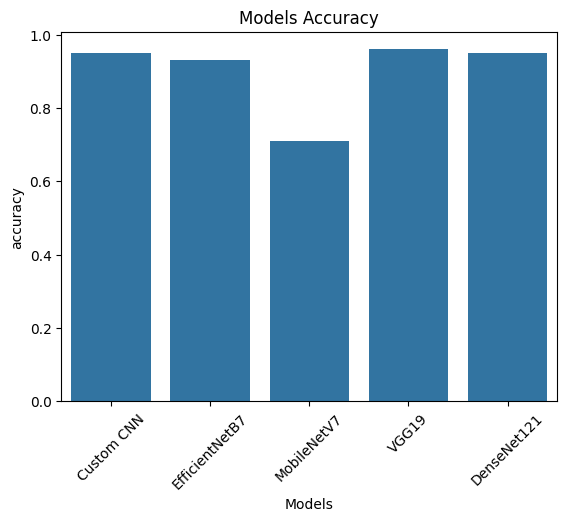

In [ ]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

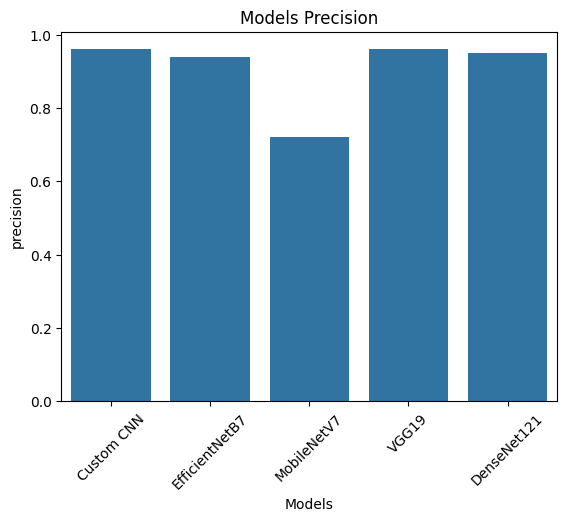

In [ ]:
sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Precision")
plt.show()

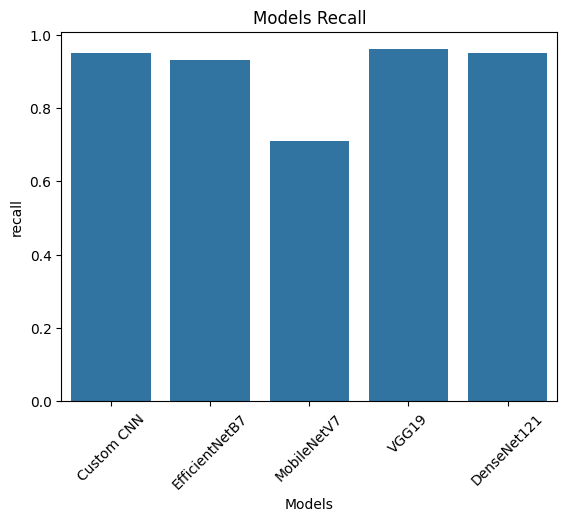

In [ ]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Recall")
plt.show()

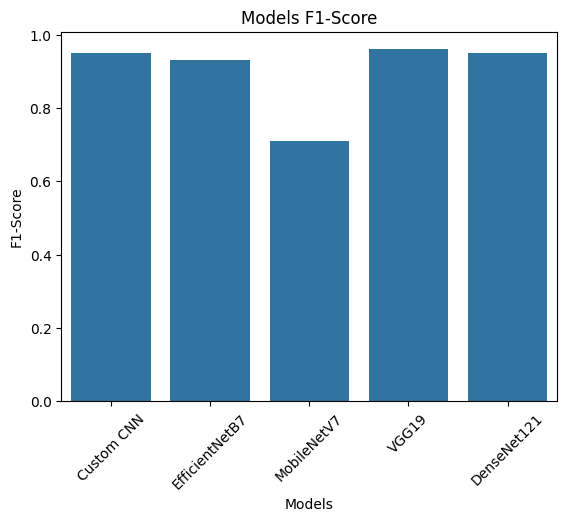

In [ ]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models F1-Score")
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


466/466 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step


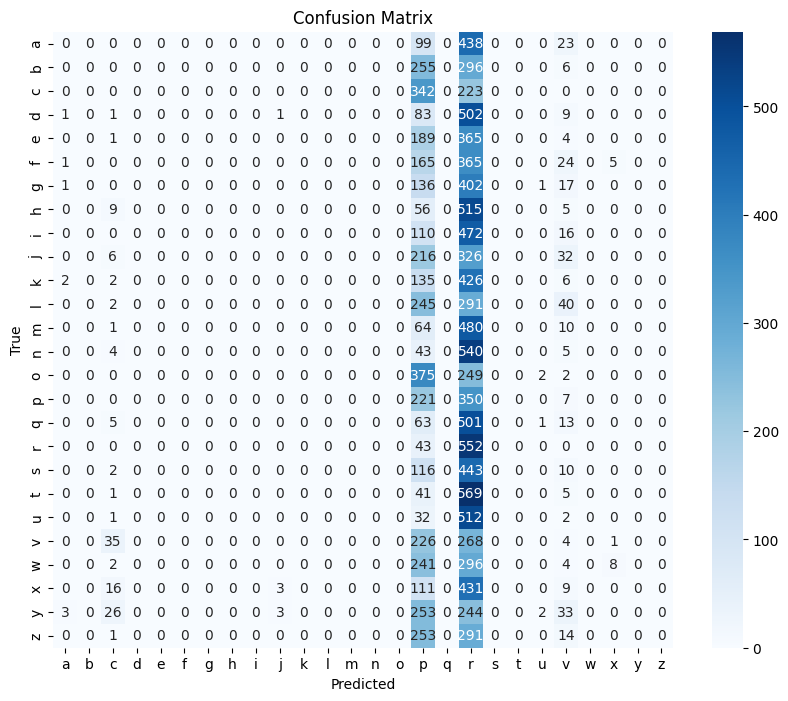

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the validation data
predictions = Den.predict(valid_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Get the true labels from the validation generator
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  # This gets the class labels as a list

# Step 3: Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**- `VGG19` shows an outstanding performance amongst all models.**

**- Due technical reasons in the next section `Post-processing`, it shows that `DenseNet121` has better performance than `VGG19` on external images, which will be used.**

**- The `Custom CNN` shows an excellent performance on the testing set on few number of epochs, it can be enhanced with more epochs and maybe data augmentation**

# 6) Post-Processing
#### **THIS SECTION IS ABOUT `Computer Vision` TECHNIQUES**

Gambar akan diambil dari pengguna/eksternal untuk diproses dan dimasukkan ke dalam model kami. Beberapa TEKNIK VISI KOMPUTER TINGKAT RENDAH digunakan untuk meningkatkan gambar input, baik itu teks atau tulisan tangan. Teknik-teknik tersebut adalah sebagai berikut:

- Binarisasi: Fungsi binarisasi menerapkan binarisasi Otsu pada gambar skala abu-abu, menghasilkan gambar biner.

- Dilasi: Fungsi dilasi melakukan dilasi morfologi pada gambar biner. Tingkat dilasi disesuaikan berdasarkan apakah sedang memproses kata atau karakter.

- Menemukan Persegi Panjang: Fungsi find_rect mengidentifikasi persegi panjang pembatas dalam gambar biner, menyusunnya berdasarkan koordinat x (dari Kiri ke Kanan).

Ekstraksi Karakter: Fungsi ekstraksi menggunakan teknik-teknik di atas untuk mengekstraksi karakter dari gambar. Fungsi ini terlebih dahulu mengidentifikasi kata, kemudian mengekstrak karakter dari setiap kata, dan dengan menggunakan model deep learning pra-terlatih, mengenali setiap karakter.

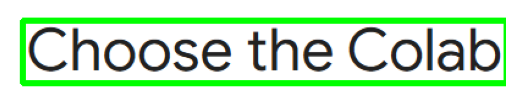

--> choosethecoiab


In [ ]:
import keras
# Computer Vision - Low level techniques
def load_model():
    model_path = '/content/DenseNet121_model.keras'
    model = keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])

    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters

    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image
    del _, bin_img, full_dil_img                          # for better memory usage

    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word

        del _, bin_img, dil_img

        for char in char_parts:
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)

            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list

            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space

    del model
    show_image(image)
    return ''.join(chars[:-1])
img4 = read_image('/content/Screenshot 2024-10-24 000400.png')
text = extract(img4)
print('-->',text)

# 7) Conclusion
dari percobaan yang kita lakukan didapat bahwa model yang terbaik untuk melakukan OCR ada pada model DenseNet121.keras yang sudah dilatih dimana dapat dilihat pula grafik yang diberikan tidak ada nya overfitting yang signifikan dan dalam coffussion matix sangat bagus

# END OF THE NOTEBOOK